In [1]:
import pathlib

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from PIL import Image
from scipy.stats import mannwhitneyu
from behavioral_analysis.moseq_tools.plots import create_similarity_dendrogram
from behavioral_analysis.pandas_tools.filter import get_modified_zscore_filter
from behavioral_analysis.tracking_tools.plots import normalize_keypoint_df_for_plotting, plot_keypoint_instance, plot_single_trajectory_overview
from behavioral_analysis.utility.builtin_classes.dicts import invert_flat_dict
from behavioral_analysis.utility.builtin_classes.objects import load_object
from behavioral_analysis.visualization.cv2_funcs import add_rgba_overlay_to_frame, fig2cv2, extract_reoriented_roi_around_point
from behavioral_analysis.visualization.matplotlib_funcs import copy_figure, create_canvas, multiply_ax_limits, rainbow_text
from behavioral_analysis.visualization.pil_funcs import ensure_pil_image, stitch_image_list, resize_with_preserved_aspect_ratio
from behavioral_analysis.visualization.plots import plot_polygon
from behavioral_analysis.visualization.video_funcs import get_frames, get_video_shape
from tqdm.cli import tqdm

d:\BITrusted\conda_envs\manuscript2024\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
root_dir = pathlib.Path(r"I:\2024_manuscript")
video_dir = root_dir / "videos"
data_output_dir = root_dir / "data_output"
plot_output_dir = root_dir / "plot_output"
trajectory_dir = plot_output_dir / "trajectory_plots"
frame_dir = plot_output_dir / "frames"

data_output_dir.mkdir(exist_ok=True, parents=True)
trajectory_dir.mkdir(exist_ok=True, parents=True)
frame_dir.mkdir(exist_ok=True, parents=True)

In [3]:
# global parameters
px_per_mm = 0.8653421633554084  # 1.00944  # calculated in SimBA
contact_threshold = 100  # mm

minimum_syllable_onset_frequency = 0.005
sig_syllables =     [   5,    7,    10, 12, 13, 18, 23, 30]

fps = 25.23
start_frame_limit = int(fps * 30)  # 30 seconds
end_frame_limit = int(fps * 60 * 20)  # 20 minutes

edge_length = 453
diagonal_length = np.sqrt(2) * edge_length

sig_color = sns.color_palette("colorblind")[1]


In [4]:
# plotting parameters

sns.set_theme(style="white")

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rcParams["ps.fonttype"] = 42  # set type 42 (truetype) fonts for ps, instead of type 3
plt.rcParams["pdf.fonttype"] = 42  # set type 42 (truetype) fonts for pdf, instead of type 3
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE, title_fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

plt.rc("lines", markersize=2, linewidth=1)
plt.rc("axes", linewidth=0.5)

plt.rc("xtick", bottom=True)
plt.rcParams["xtick.major.size"] = 3
plt.rcParams["xtick.major.width"] = 0.5
plt.rc("ytick", left=True)
plt.rcParams["ytick.major.size"] = 3
plt.rcParams["ytick.major.width"] = 0.5

# plt.rc("text", usetex=True)
# plt.rc("text.latex", preamble=r"\usepackage[usenames]{xcolor}")

default_dpi = 300

# Supplementary Figure 1

## Panel A

In [5]:
sampled_syllable_trajectory_df = load_object(data_output_dir / "sampled_syllable_trajectory_df.pkl")
skeleton_df = load_object(data_output_dir / "skeleton_df.pkl")

In [6]:
for syll in tqdm(sampled_syllable_trajectory_df.index.get_level_values("syllable").unique()):
    canvas = create_canvas(256, 256, dpi=default_dpi, alpha=1)
    ax = canvas.gca()

    plot_single_trajectory_overview(sampled_syllable_trajectory_df.loc[syll], skeleton_df, ax=ax, keypoint_kwargs=dict(s=2, lw=1), skeleton_kwargs=dict(lw=1))
    multiply_ax_limits(ax, 1.1)
    canvas.savefig(trajectory_dir / f"Syllable{syll}_labeled.png", dpi=default_dpi)
    plt.close(canvas)


100%|██████████| 32/32 [00:20<00:00,  1.58it/s]


32it [00:00, 711.03it/s]


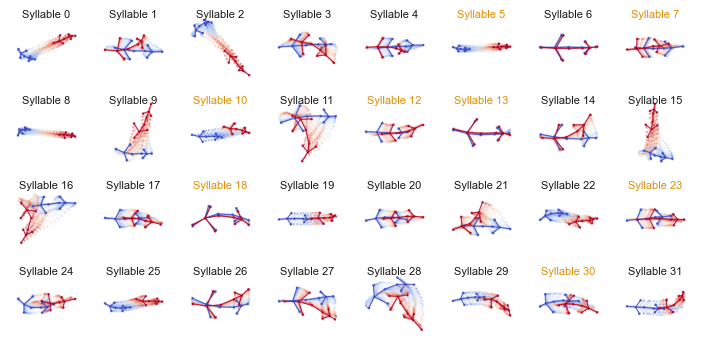

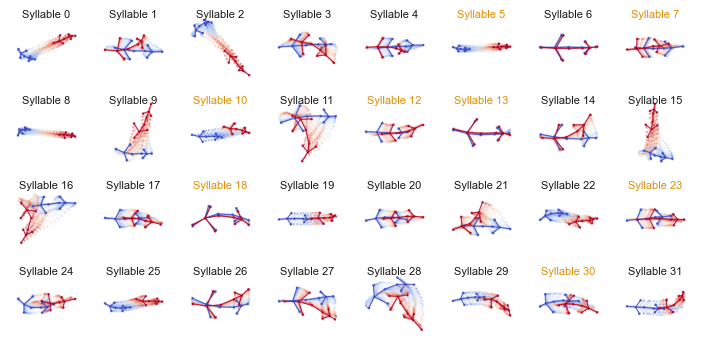

In [7]:
fig_size_cm = (18, 9)
fig_size = (fig_size_cm[0]/2.54, fig_size_cm[1]/2.54)
dpi = default_dpi

sylls_to_stitch = list(range(32))
syll_path_list = [trajectory_dir / f"Syllable{syll}_labeled.png" for syll in sylls_to_stitch]
image_list = [ensure_pil_image(str(path)) for path in syll_path_list]

fig, axs = plt.subplots(ncols=8, nrows=4, figsize=fig_size)
fig.subplots_adjust(wspace=0, hspace=0)

for syll, ax in tqdm(zip(sampled_syllable_trajectory_df.index.get_level_values("syllable").unique(), axs.flatten())):
    ax.set_aspect("equal")
    ax.axis("off")
    ax.imshow(np.array(image_list[syll]))
    multiply_ax_limits(ax, 1.15)
    ax.text(0.5, 0.95, f"Syllable {syll}", ha="center", va="center", transform=ax.transAxes, fontdict=dict(size=SMALL_SIZE, color="k" if syll not in sig_syllables else sig_color))

fig.tight_layout()
fig.savefig(plot_output_dir / "SupplFig1PanelA.svg", dpi=default_dpi)
fig

## Panel B

In [8]:
moseq_df = load_object(data_output_dir / "moseq_df.pkl")
scored_contact_series = load_object(data_output_dir / "scored_active_contact_series.pkl")
renamed_contact_quartile_series = load_object(data_output_dir / "renamed_contact_quartile_series.pkl")

Dyadic, No vs Solitary:
MannwhitneyuResult(statistic=np.float64(13351.0), pvalue=np.float64(0.5058998480457292)) False
Dyadic, Yes vs Solitary:
MannwhitneyuResult(statistic=np.float64(10782.0), pvalue=np.float64(0.04533358334827463)) False
Dyadic, 1st vs Solitary:
MannwhitneyuResult(statistic=np.float64(11499.0), pvalue=np.float64(0.1641526408919639)) False
Dyadic, 2nd vs Solitary:
MannwhitneyuResult(statistic=np.float64(13107.0), pvalue=np.float64(0.6388891758854338)) False
Dyadic, 3rd vs Solitary:
MannwhitneyuResult(statistic=np.float64(12821.0), pvalue=np.float64(0.9028849319669562)) False
Dyadic, 4th vs Solitary:
MannwhitneyuResult(statistic=np.float64(13332.5), pvalue=np.float64(0.39859291373439787)) False


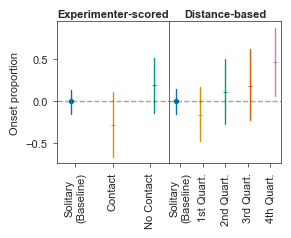

In [9]:
scored_contact_moseq_df = moseq_df.join(scored_contact_series)
scored_contact_moseq_df["comparison_group"] = scored_contact_moseq_df["context"] + scored_contact_moseq_df["contact"].apply({True: ", Yes", False: ", No", np.nan: ""}.get)
plot_syllable_proportions = scored_contact_moseq_df[scored_contact_moseq_df["onset"]]
plot_syllable_proportions = plot_syllable_proportions.groupby(["comparison_group", "track"])["syllable"].value_counts(normalize=True).reset_index()
filtered_plot_syllable_proportions = plot_syllable_proportions[plot_syllable_proportions["syllable"].isin(sig_syllables)]

baseline_group = "Solitary"
for syll, syll_df in filtered_plot_syllable_proportions.groupby("syllable"):
    baseline_mean = syll_df[syll_df["comparison_group"].eq(baseline_group)]["proportion"].mean()
    baseline_std = syll_df[syll_df["comparison_group"].eq(baseline_group)]["proportion"].std()
    filtered_plot_syllable_proportions.loc[syll_df.index, "proportion"] -= baseline_mean
    filtered_plot_syllable_proportions.loc[syll_df.index, "proportion"] /= baseline_std

n_tests = 6
p_threshold = 0.05

base_g = filtered_plot_syllable_proportions[filtered_plot_syllable_proportions["comparison_group"].eq(baseline_group)]
for g, g_df in filtered_plot_syllable_proportions.groupby("comparison_group"):
    if g == baseline_group:
        continue
    print(f"{g} vs {baseline_group}:")
    res = mannwhitneyu(g_df["proportion"], base_g["proportion"])
    print(res, res.pvalue < (p_threshold / n_tests))

filtered_plot_syllable_proportions.loc[:, "comparison_group"] = filtered_plot_syllable_proportions["comparison_group"].replace(
    {"Solitary": "Solitary\n(Baseline)", "Dyadic, Yes": "Contact", "Dyadic, No": "No Contact"})

cmap = sns.color_palette("colorblind")

fig_size_cm = (7.5, 6)
fig_size = (fig_size_cm[0]/2.54, fig_size_cm[1]/2.54)
fig, axs = plt.subplots(1, 2, figsize=fig_size, sharey=True, gridspec_kw={"width_ratios": [1, 1], "wspace": 0})

solitary_data = filtered_plot_syllable_proportions.copy()
solitary_data.loc[solitary_data["comparison_group"].ne("Solitary"), "proportion"] = np.nan

dyadic_data = filtered_plot_syllable_proportions.copy()
dyadic_data.loc[solitary_data["comparison_group"].eq("Solitary"), "proportion"] = np.nan

ax = axs[0]
sns.pointplot(solitary_data, legend=False, ms=2, lw=1,
              x="comparison_group", y="proportion", hue="comparison_group", 
              order=["Solitary\n(Baseline)", "Contact", "No Contact"], hue_order=["Solitary\n(Baseline)", "Contact", "No Contact"], palette="colorblind", 
              marker=["o", "+", "+"],
              dodge=0.2, linestyle="none", errorbar=("ci", 95), ax=ax)

sns.pointplot(dyadic_data, legend=False, ms=3, lw=1,
              x="comparison_group", y="proportion", hue="comparison_group", 
              order=["Solitary\n(Baseline)", "Contact", "No Contact"], hue_order=["Solitary\n(Baseline)", "Contact", "No Contact"], palette="colorblind", 
              marker=["o", "+", "+"],
              dodge=0.2, linestyle="none", errorbar=("ci", 95), ax=ax)

ax.tick_params(axis='x', labelrotation=90)
ax.set_title("Experimenter-scored", fontdict={"weight": "bold"}, pad=3)
ax.set_ylabel("Onset proportion")
ax.set_xlabel("")
ax.axhline(0, c="k", ls="--", alpha=0.4)

scored_contact_moseq_df = moseq_df.join(renamed_contact_quartile_series)
scored_contact_moseq_df["comparison_group"] = scored_contact_moseq_df["context"] + scored_contact_moseq_df["contact_quartile"].apply(lambda x: ", " + x if not pd.isna(x) else "")
plot_syllable_proportions = scored_contact_moseq_df[scored_contact_moseq_df["onset"]]
plot_syllable_proportions = plot_syllable_proportions.groupby(["comparison_group", "track"])["syllable"].value_counts(normalize=True).reset_index()
filtered_plot_syllable_proportions = plot_syllable_proportions[plot_syllable_proportions["syllable"].isin(sig_syllables)]

baseline_group = "Solitary"
for syll, syll_df in filtered_plot_syllable_proportions.groupby("syllable"):
    baseline_mean = syll_df[syll_df["comparison_group"].eq(baseline_group)]["proportion"].mean()
    baseline_std = syll_df[syll_df["comparison_group"].eq(baseline_group)]["proportion"].std()
    filtered_plot_syllable_proportions.loc[syll_df.index, "proportion"] -= baseline_mean
    filtered_plot_syllable_proportions.loc[syll_df.index, "proportion"] /= baseline_std

base_g = filtered_plot_syllable_proportions[filtered_plot_syllable_proportions["comparison_group"].eq(baseline_group)]
for g, g_df in filtered_plot_syllable_proportions.groupby("comparison_group"):
    if g == baseline_group:
        continue
    print(f"{g} vs {baseline_group}:")
    res = mannwhitneyu(g_df["proportion"], base_g["proportion"])
    print(res, res.pvalue < (p_threshold / n_tests))

filtered_plot_syllable_proportions.loc[:, "comparison_group"] = filtered_plot_syllable_proportions["comparison_group"].replace(
    {"Solitary": "Solitary\n(Baseline)", "Dyadic, 1st": "1st Quart.", "Dyadic, 2nd": "2nd Quart.", "Dyadic, 3rd": "3rd Quart.", "Dyadic, 4th": "4th Quart."})

solitary_data = filtered_plot_syllable_proportions.copy()
solitary_data.loc[solitary_data["comparison_group"].ne("Solitary"), "proportion"] = np.nan

dyadic_data = filtered_plot_syllable_proportions.copy()
dyadic_data.loc[solitary_data["comparison_group"].eq("Solitary"), "proportion"] = np.nan

ax = axs[1]

sns.pointplot(solitary_data, legend=False, ms=2, lw=1,
              x="comparison_group", y="proportion", hue="comparison_group", 
              order=["Solitary\n(Baseline)", "1st Quart.", "2nd Quart.", "3rd Quart.", "4th Quart."], hue_order=["Solitary\n(Baseline)", "1st Quart.", "2nd Quart.", "3rd Quart.", "4th Quart."], palette="colorblind", 
              marker=["o", "+", "+", "+", "+"],
              dodge=0.4, linestyle="none", errorbar=("ci", 95), ax=ax)

sns.pointplot(dyadic_data, legend=False, ms=3, lw=1,
              x="comparison_group", y="proportion", hue="comparison_group", 
              order=["Solitary\n(Baseline)", "1st Quart.", "2nd Quart.", "3rd Quart.", "4th Quart."], hue_order=["Solitary\n(Baseline)", "1st Quart.", "2nd Quart.", "3rd Quart.", "4th Quart."], palette="colorblind", 
              marker=["o", "+", "+", "+", "+"],
              dodge=0.4, linestyle="none", errorbar=("ci", 95), ax=ax)

ax.tick_params(axis='x', labelrotation=90)
ax.set_title("Distance-based", fontdict={"weight": "bold"}, pad=3)
ax.set_xlabel("")
ax.tick_params(axis="y", left=False)
ax.axhline(0, c="k", ls="--", alpha=0.4)

fig.tight_layout()

# fig.suptitle("DM frequencies are contact-independent:", fontweight="bold", fontsize=SMALL_SIZE)
fig.tight_layout()
fig.subplots_adjust(top=0.925)

fig.savefig(plot_output_dir / "SupplFig1PanelB.svg", dpi=default_dpi)

## Panel C

In [10]:
syllable_example_stat_df = load_object(data_output_dir / "syllable_example_stat_df.pkl")

median_distance 50.0 0.057494842322428526
median_direction 39.0 0.016635387847846135
viewing_direction_delta 33.0 0.0023809931262656512
['DU', 'DM', 'Filtered']


C:\Users\rittmart\AppData\Local\Temp\ipykernel_105320\3000358638.py:65: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  fig.tight_layout()


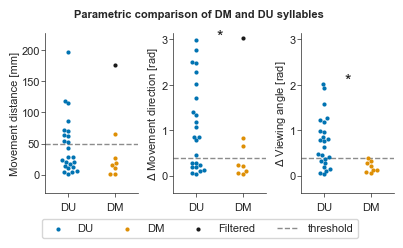

In [11]:
title_lookup_dict = {
    "median_distance": "Movement distance [mm]",
    "median_direction": "$\Delta$ Movement direction [rad]",
    "viewing_direction_delta": "$\Delta$ Viewing angle [rad]"
}

parameter_cutoffs = {
    "median_distance": 50,
    "median_direction": np.pi / 8,
    "viewing_direction_delta": np.pi / 8
}

palette = {"DU": sns.color_palette("colorblind")[0], "DM": sig_color, "Filtered": "k"}

plot_df = syllable_example_stat_df.melt(id_vars="sig_syll", ignore_index=False).set_index(["sig_syll", "variable"], append=True).reset_index()
plot_df["Syllable"] = plot_df["sig_syll"].apply(lambda x: "DM" if x else "DU")
plot_df["filtered"] = plot_df.groupby(["sig_syll", "variable"])["value"].apply(lambda x: get_modified_zscore_filter(x, threshold=5)).droplevel(level=[0, 1])
plot_df.loc[plot_df["filtered"], "Syllable"] = "Filtered"
plot_df["syll_type"] = plot_df["sig_syll"].apply(lambda x: "DM" if x else "DU")
plot_df = plot_df.reset_index()

fig_size_cm = (10.5, 6)
fig_size = (fig_size_cm[0]/2.54, fig_size_cm[1]/2.54)

f = sns.FacetGrid(data=plot_df, hue="Syllable", hue_order=["DU", "DM", "Filtered"], palette=palette, col="variable", sharey=False, legend_out=False, height=fig_size[1], aspect=0.6)
f.map_dataframe(sns.swarmplot, x="syll_type", y="value", s=3)
f.set_titles("")
f.set_xlabels("")

for ax, col_name in zip(f.axes.flatten(), f.col_names):
    multiply_ax_limits(ax, limit_factor=(1, 1.2))
    subplot_df = plot_df[plot_df["variable"].eq(col_name)]
    g1 = subplot_df[subplot_df["sig_syll"] & ~subplot_df["filtered"]]["value"].astype(float)
    g2 = subplot_df[~subplot_df["sig_syll"] & ~subplot_df["filtered"]]["value"].astype(float)
    stat, p_value = mannwhitneyu(g1, g2, alternative="less")

    print(col_name, stat, p_value)
    if p_value < 0.05 / len(title_lookup_dict):
        max_y = subplot_df["value"].max()
        ax.text(0.5, max_y*0.95, '*', ha='center', va='bottom', color='k', fontsize=BIGGER_SIZE)

    h_line = ax.axhline(parameter_cutoffs[col_name], ls="--", c="k", alpha=0.5)

    if "direction" in col_name:
        ax.set_ylim([-np.pi/8, np.pi])

# Adding a tick label for the threshold
for ax, col_name in zip(f.axes.flatten(), f.col_names):
    ax.set_ylabel(title_lookup_dict[col_name], labelpad=1)
    ax.tick_params(axis="y", pad=1)

axes = f.axes.flatten()
l_handles, l_labels = axes[1].get_legend_handles_labels()
print(l_labels)
l_handles += [h_line]
l_labels += ["threshold"]
f.axes.flatten()[-1].legend(handles=l_handles, labels=l_labels, ncols=4, bbox_to_anchor=(0.0, 0.015, 0.9, 0.1), bbox_transform=f.figure.transFigure)
f.figure.suptitle("Parametric comparison of DM and DU syllables", weight="bold", fontsize=SMALL_SIZE)

fig = f.figure

fig.set_figwidth(fig_size[0])
fig.set_figheight(fig_size[1])
fig.subplots_adjust(bottom=0.2)
fig.tight_layout()

fig.savefig(plot_output_dir / "SupplFig1PanelC.svg", dpi=default_dpi)

In [12]:
for var, var_df in plot_df.groupby("variable"):
    print("\n", var)
    print("Sig")
    print(var_df[var_df["sig_syll"] & var_df["value"].le(parameter_cutoffs[var])]["syll"].values)
    print(var_df[var_df["sig_syll"] & var_df["value"].gt(parameter_cutoffs[var])]["syll"].values)

    print("\nnon-sig")
    print(var_df[~var_df["sig_syll"] & var_df["value"].le(parameter_cutoffs[var])]["syll"].values)
    print(var_df[~var_df["sig_syll"] & var_df["value"].gt(parameter_cutoffs[var])]["syll"].values)



 median_direction
Sig
[ 5 10 12 23 30]
[ 7 13 18]

non-sig
[ 8 17 19 20 22 24 25 29 31]
[ 0  1  2  3  4  6  9 11 14 15 16 21 26 27 28]

 median_distance
Sig
[ 7 12 13 18 23 30]
[ 5 10]

non-sig
[ 1  3  4  6 11 14 16 17 20 21 24 26 27 28]
[ 0  2  8  9 15 19 22 25 29 31]

 viewing_direction_delta
Sig
[ 5  7 10 12 13 18 23 30]
[]

non-sig
[ 0  6  8 17 20 24 25 26]
[ 1  2  3  4  9 11 14 15 16 19 21 22 27 28 29 31]


# Supplementary Figure 2

## Panel A

In [13]:
joint_removed_syll_bout_df = load_object(data_output_dir / "joint_removed_syll_bout_df.pkl")
behavior_df = load_object(data_output_dir / "behavior_df.pkl")

In [14]:
removed_syll_bout_df = joint_removed_syll_bout_df[~joint_removed_syll_bout_df["randomized"]]
removed_syll_bout_df

bout_feature                                 end_frame  bout_length  \
track                           frame_index                           
1 - 21-02-24.analysis           1179              1184            6   
                                3016              3031           16   
                                4140              4200           61   
                                4555              4780          226   
                                7962              7964            3   
...                                                ...          ...   
7&10 - 20-03-24.analysis_track1 27336            27483          148   
                                28809            29339          531   
                                29453            29473           21   
                                29583            29627           45   
                                30013            30048           36   

bout_feature                                 behavior_name  dyadic_bout  \
track                           frame_index                               
1 - 21-02-24.analysis           1179                     1        False   
                                3016                     1        False   
                                4140                     1        False   
                                4555                     1        False   
                                7962                     1        False   
...                                                    ...          ...   
7&10 - 20-03-24.analysis_track1 27336                    1         True   
                                28809                    1         True   
                                29453                    1         True   
                                29583                    1         True   
                                30013                    1         True   

bout_feature                                 randomized  
track                           frame_index              
1 - 21-02-24.analysis           1179              False  
                                3016              False  
                                4140              False  
                                4555              False  
                                7962              False  
...                                                 ...  
7&10 - 20-03-24.analysis_track1 27336             False  
                                28809             False  
                                29453             False  
                                29583             False  
                                30013             False  

[1212 rows x 5 columns]

1 - 21-02-24.analysis


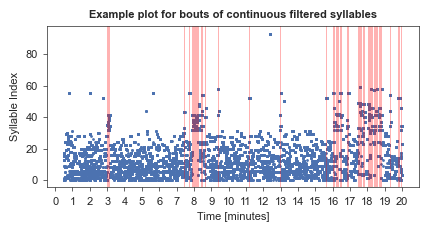

In [15]:
track_name = behavior_df.index.get_level_values("track").unique()[0]
print(track_name)

pl_sr = behavior_df.loc[track_name].stack()
span_df = removed_syll_bout_df.loc[track_name]
span_df = span_df[span_df["behavior_name"].eq(1)].reset_index()
span_df["start_seconds"] = span_df["frame_index"] / fps
span_df["end_seconds"] = span_df["end_frame"] / fps

# x ticks to time, based on fps=25.25
pl_df = pl_sr[pl_sr].reset_index()
pl_df["time_seconds"] = pl_df["frame_index"] / fps

ax = pl_df.plot(kind="scatter", x="time_seconds", y="behavior_name", figsize=(20, 5), s=1)
ax.set_xticks(np.arange(0, 60*60+60, 60*1))
ax.set_xticklabels(ax.get_xticks(), rotation=0)

for _, row in span_df.iterrows():
    ax.axvspan(row["start_seconds"], row["end_seconds"], facecolor="red", edgecolor="none", alpha=0.3)

def format_timestamp(seconds_tick, _):
    try:
        return int(seconds_tick/60)
    except IndexError:
        pass

ax.xaxis.set_major_formatter(format_timestamp)  # internally creates FuncFormatter

ax.set_ylabel("Syllable Index")
ax.set_xlabel("Time [minutes]")
ax.set_title("Example plot for bouts of continuous filtered syllables", fontweight="bold")

fig = ax.get_figure()
fig_size_cm = (11, 6)
fig_size = (fig_size_cm[0]/2.54, fig_size_cm[1]/2.54)

fig.set_figwidth(fig_size[0])
fig.set_figheight(fig_size[1])

fig.tight_layout()
fig.savefig(plot_output_dir / "SupplFig2PanelA.svg", dpi=default_dpi)


## Panel B

Corrected for 6.0 Tests
Comparison 1: (False, False) vs (False, True) - Mann-Whitney U test: U=497454.5, p-value=6.195826055274549e-25, significant=True
Comparison 2: (False, False) vs (True, False) - Mann-Whitney U test: U=163370.0, p-value=0.008534599979510064, significant=False
Comparison 3: (False, False) vs (True, True) - Mann-Whitney U test: U=572765.0, p-value=2.515682119320931e-14, significant=True
Comparison 4: (False, True) vs (True, False) - Mann-Whitney U test: U=312124.5, p-value=6.665880613259587e-52, significant=True
Comparison 5: (False, True) vs (True, True) - Mann-Whitney U test: U=1231801.5, p-value=1.1785535944061468e-06, significant=True
Comparison 6: (True, False) vs (True, True) - Mann-Whitney U test: U=849886.5, p-value=1.4162427429077503e-36, significant=True


C:\Users\rittmart\AppData\Local\Temp\ipykernel_105320\1637752498.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xticklabels)


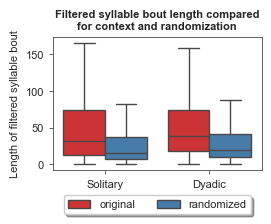

In [16]:
# Create the boxplot
fig, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(data=joint_removed_syll_bout_df, x="dyadic_bout", y="bout_length", hue="randomized", showfliers=False, ax=ax, palette="Set1")
ax.set_title("Bout Length by Dyadic Bout and Randomized Status")
ax.set_xlabel("Dyadic Bout")
ax.set_ylabel("Bout Length")
plt.legend(title="Randomized")

# Perform Mann-Whitney U test between all four groups
groups = joint_removed_syll_bout_df.groupby(["dyadic_bout", "randomized"])["bout_length"]
group_combinations = [(False, False), (False, True), (True, False), (True, True)]

# Bonferroni correction
alpha = 0.05
num_tests = len(group_combinations) * (len(group_combinations) - 1) / 2
corrected_alpha = alpha / num_tests
print(f"Corrected for {num_tests} Tests")

# Check for significance with Bonferroni correction
for i, (group1, group2) in enumerate([(g1, g2) for g1 in group_combinations for g2 in group_combinations if g1 < g2]):
    group1_data = groups.get_group(group1)
    group2_data = groups.get_group(group2)
    stat, p_value = mannwhitneyu(group1_data, group2_data)
    significant = p_value < corrected_alpha
    print(f"Comparison {i+1}: {group1} vs {group2} - Mann-Whitney U test: U={stat}, p-value={p_value}, significant={significant}")

ax.set_ylabel("Length of filtered syllable bout")
ax.set_xlabel("")
ax.set_title("Filtered syllable bout length compared\nfor context and randomization", fontweight="bold")

x_ticklabels = ax.get_xticklabels()
new_xticklabels = ["Solitary" if l.get_text()=="False" else "Dyadic" for l in x_ticklabels]
ax.set_xticklabels(new_xticklabels)

handles, labels = ax.get_legend_handles_labels()
labels = ["randomized" if l=="True" else "original" for l in labels]
ax.legend(handles=handles, labels=labels, loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=5)

fig = ax.get_figure()
fig_size_cm = (7, 6)
fig_size = (fig_size_cm[0]/2.54, fig_size_cm[1]/2.54)

fig.set_figwidth(fig_size[0])
fig.set_figheight(fig_size[1])

fig.tight_layout()
fig.savefig(plot_output_dir / "SupplFig2PanelB.svg", dpi=default_dpi)


## Panel C & D & E & F

In [17]:
bout_frame_df = load_object(data_output_dir / "bout_frame_df.pkl")
bout_track_df = load_object(data_output_dir / "bout_track_df.pkl")
skeleton_df = load_object(data_output_dir / "skeleton_df.pkl")

In [18]:
out_path_dict = {}

for row, frame_data in tqdm(bout_frame_df.iterrows(), total=len(bout_frame_df)):
    frame_keypoint_df = bout_track_df.loc[row].unstack("keypoint_name").T
    
    video_name = pathlib.Path(frame_data["video_path"]).with_suffix("").name
    frame_index = row[1]

    frame = get_frames(frame_data["video_path"], [frame_index])[0]
    canvas_shape = get_video_shape(frame_data["video_path"])[:2][::-1]
    frame_canvas = create_canvas(*canvas_shape, dpi=default_dpi)
    ax = frame_canvas.gca()

    median_location = tuple(frame_keypoint_df.median(axis=0).astype(int)[["x", "y"]].values)
    roi_size = 256//2

    plot_keypoint_instance(frame_keypoint_df, skeleton_df, ax=ax, alpha=0.3, skeleton_kwargs={"color": "white", "lw": 1}, keypoint_kwargs=dict(s=2, lw=1))
    frame = add_rgba_overlay_to_frame(frame, fig2cv2(frame_canvas))
    frame = extract_reoriented_roi_around_point(frame, center_point=median_location, roi_shape=(roi_size, roi_size), roi_orientation=0.)

    image = ensure_pil_image(frame[:, :, ::-1])
    out_path = frame_dir / f"{video_name}_{frame_index}_{frame_data['dyadic_bout']}_{frame_data['randomized']}.png"
    out_path_dict[(video_name, frame_index, frame_data['dyadic_bout'], frame_data['randomized'])] = str(out_path.absolute())

    image.save(out_path)
    plt.close(frame_canvas)

100%|██████████| 36/36 [00:06<00:00,  5.69it/s]


In [19]:
out_path_series = pd.Series(out_path_dict)
out_path_series.index.names = ["video_name", "frame_index", 'dyadic_bout', 'randomized']
out_path_series

video_name        frame_index  dyadic_bout  randomized
25 - 21-02-24     21504        False        False         I:\2024_manuscript\plot_output\frames\25 - 21-...
10 - 21-02-24     8828         False        False         I:\2024_manuscript\plot_output\frames\10 - 21-...
1 - 21-02-24      26879        False        False         I:\2024_manuscript\plot_output\frames\1 - 21-0...
7 - 21-02-24      22541        False        False         I:\2024_manuscript\plot_output\frames\7 - 21-0...
1 - 21-02-24      11705        False        False         I:\2024_manuscript\plot_output\frames\1 - 21-0...
16 - 23-02-24     27906        False        False         I:\2024_manuscript\plot_output\frames\16 - 23-...
7 - 21-02-24      25860        False        False         I:\2024_manuscript\plot_output\frames\7 - 21-0...
1 - 21-02-24      28363        False        False         I:\2024_manuscript\plot_output\frames\1 - 21-0...
22 - 23-02-24     13518        False        False         I:\2024_manuscript\plot

[('dyadic_bout', np.False_), ('randomized', np.False_)]


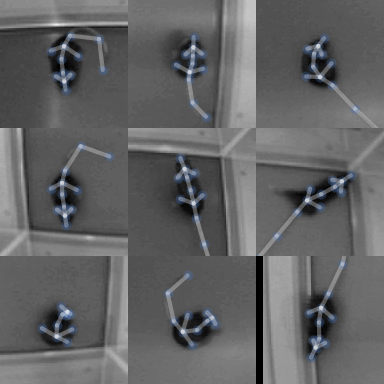

[('dyadic_bout', np.False_), ('randomized', np.True_)]


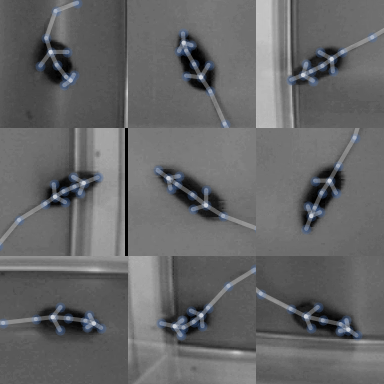

[('dyadic_bout', np.True_), ('randomized', np.False_)]


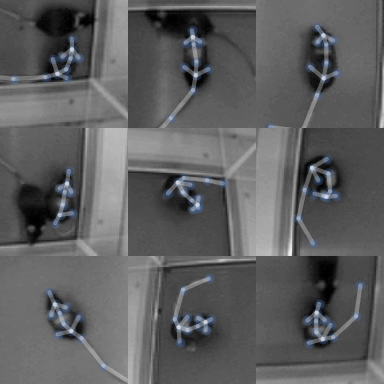

[('dyadic_bout', np.True_), ('randomized', np.True_)]


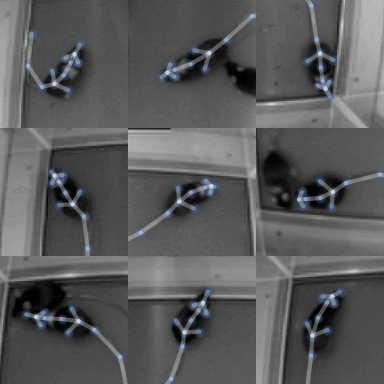

In [20]:
stitched_image_dict = {}
for g, g_series in out_path_series.groupby(["dyadic_bout", "randomized"]):
    print(list(zip(["dyadic_bout", "randomized"], g)))
    image_path_list = list(g_series)
    image_list = [ensure_pil_image(p) for p in image_path_list]
    stitched_image = stitch_image_list(*image_list, columns=3)

    stitched_image_dict[g] = stitched_image
    display(stitched_image)

In [21]:
fig_size_cm = (8.9, 8.9)
fig_size = (fig_size_cm[0]/2.54, fig_size_cm[1]/2.54)
dpi = default_dpi

fig_size_px = (int(fig_size[0]*dpi), int(fig_size[1]*dpi))

plot_tuples = [
    ((False, False), plot_output_dir / "SupplFig2PanelC.png"),  # solitary, real filtered bouts
    ((True, False), plot_output_dir / "SupplFig2PanelD.png"),  # dyadic, real filtered bouts
    ((False, True), plot_output_dir / "SupplFig2PanelE.png"),  # solitary, randomized bouts
    ((True, True), plot_output_dir / "SupplFig2PanelF.png")  # dyadic, randomized bouts
]

for k, p in plot_tuples:
    stitched_image = stitched_image_dict[*k]
    stitched_image = resize_with_preserved_aspect_ratio(stitched_image, fig_size_px, resample=Image.Resampling.LANCZOS)

    print(stitched_image.width / dpi * 2.54, stitched_image.height / dpi * 2.54)

    stitched_image.save(p, dpi=(dpi, dpi))

8.898466666666668 8.898466666666668
8.898466666666668 8.898466666666668
8.898466666666668 8.898466666666668
8.898466666666668 8.898466666666668


# Supplementary Figure 3

## Panel A

In [22]:
distance_df = pd.read_csv(root_dir / "DistanceDfExtendedData.csv", index_col=0, header=0).rename_axis("syllable", axis=1)
distance_df.index = distance_df.index.astype(int)
distance_df.columns = distance_df.columns.astype(int)
distance_df

syllable,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
syllable,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.482376,0.272215,0.504187,0.603285,0.033394,0.518091,0.503773,0.050581,0.348708,...,0.111059,0.232283,0.131231,0.054924,0.468814,0.587480,0.446910,0.282535,0.371024,0.196212
1,0.482376,0.000000,0.584258,0.086654,0.060911,0.578419,0.027776,0.030054,0.607094,0.145129,...,0.304893,0.163658,0.147216,0.348964,0.001687,0.108154,0.272551,0.260486,0.096802,0.129718
2,0.272215,0.584258,0.000000,0.366553,0.481673,0.184442,0.476287,0.485220,0.126552,0.779900,...,0.124186,0.169062,0.284479,0.192263,0.581337,0.400178,0.173720,0.130286,0.303187,0.393879
3,0.504187,0.086654,0.366553,0.000000,0.018059,0.531308,0.021040,0.028981,0.525480,0.377373,...,0.236796,0.079985,0.167705,0.310185,0.088747,0.008040,0.077032,0.111871,0.027162,0.193901
4,0.603285,0.060911,0.481673,0.018059,0.000000,0.655654,0.013032,0.026813,0.651775,0.353515,...,0.330692,0.136909,0.227273,0.412273,0.067015,0.012277,0.139147,0.194813,0.068448,0.239673
5,0.033394,0.578419,0.184442,0.531308,0.655654,0.000000,0.575629,0.562436,0.010763,0.498448,...,0.084339,0.248569,0.176520,0.045209,0.564867,0.610156,0.398398,0.236226,0.383664,0.234505
6,0.518091,0.027776,0.476287,0.021040,0.013032,0.575629,0.000000,0.010140,0.585820,0.269946,...,0.272581,0.114363,0.161529,0.339910,0.029101,0.029477,0.156546,0.176140,0.048560,0.162150
7,0.503773,0.030054,0.485220,0.028981,0.026813,0.562436,0.010140,0.000000,0.577989,0.258488,...,0.267741,0.116644,0.146169,0.329008,0.030453,0.046941,0.166256,0.184499,0.039150,0.153503
8,0.050581,0.607094,0.126552,0.525480,0.651775,0.010763,0.585820,0.577989,0.000000,0.559615,...,0.084683,0.233416,0.201383,0.066499,0.595478,0.598422,0.367502,0.224828,0.389529,0.278029


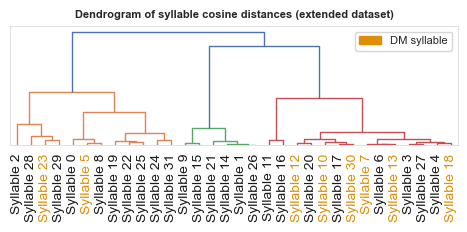

In [23]:
# sns.set(font_scale=1.0, style="white")
fig, ax = plt.subplots(figsize=(6, 4))
create_similarity_dendrogram(distance_df, ax=ax)

label_sylls = [int(l.get_text().split(" ")[-1]) for l in ax.get_xticklabels()]
label_colors = []
for s in label_sylls:
    if s in sig_syllables:
        label_colors.append(sig_color)
    else:
        label_colors.append("k")

[l.set_color(c) for l,c in zip(ax.xaxis.get_ticklabels(), label_colors)]
ax.set_title("Dendrogram of syllable cosine distances (extended dataset)", fontweight='bold')
ax.legend(handles=[mpatches.Patch(color=sig_color, label="DM syllable")])

fig_size_cm = (12, 6)
fig_size = (fig_size_cm[0]/2.54, fig_size_cm[1]/2.54)

fig.set_figwidth(fig_size[0])
fig.set_figheight(fig_size[1])

fig.tight_layout()
fig.savefig(plot_output_dir / "SupplFig3PanelA.svg", dpi=default_dpi)

## Panel B

In [24]:
syllable_transition_count_df = load_object(data_output_dir / "syllable_transition_count_df.pkl")

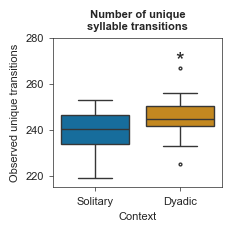

In [25]:
ax = sns.boxplot(syllable_transition_count_df, x="Context", y="observed_transitions", hue="Context", palette="colorblind")
ax.set_ylabel("Observed unique transitions")
ax.set_title("Number of unique\nsyllable transitions", fontweight='bold')
ax.annotate("*", ("Dyadic", 270), ha='center', va='center', fontsize=16)

ax.set_ylim([215, 280])

fig = ax.get_figure()

fig_size_cm = (6, 6)
fig_size = (fig_size_cm[0]/2.54, fig_size_cm[1]/2.54)

fig.set_figwidth(fig_size[0])
fig.set_figheight(fig_size[1])

fig.tight_layout()
fig.savefig(plot_output_dir / "SupplFig3PanelB.svg", dpi=default_dpi)

## Panel C

In [26]:
normed_transition_series = load_object(data_output_dir / "normed_transition_series.pkl")

In [27]:
normed_transition_series["source_DM"] = normed_transition_series.index.get_level_values("previous_behavior").isin(sig_syllables)
normed_transition_series["target_DM"] = normed_transition_series.index.get_level_values("next_behavior").isin(sig_syllables)
normed_transition_series["ratio"] = normed_transition_series["Dyadic"] / normed_transition_series["Solitary"]
normed_transition_series["source_DM"] = normed_transition_series["source_DM"].apply(lambda x: "Transition origin is DM" if x else "Transition origin is DU")
normed_transition_series["ratio"] = normed_transition_series["Dyadic"] / normed_transition_series["Solitary"]
normed_transition_series

Context                          Solitary    Dyadic                source_DM  \
previous_behavior next_behavior                                                
0                 2              0.005805  0.008883  Transition origin is DU   
                  5              0.617426  0.571531  Transition origin is DU   
                  8              0.016690  0.019730  Transition origin is DU   
                  17             0.146397  0.131832  Transition origin is DU   
                  19             0.035124  0.042621  Transition origin is DU   
...                                   ...       ...                      ...   
30                16             0.023093  0.030256  Transition origin is DM   
                  23             0.629819  0.656990  Transition origin is DM   
31                0              0.719482  0.725083  Transition origin is DU   
                  19             0.184355  0.130295  Transition origin is DU   
                  23             0.058296  0.077666  Transition origin is DU   

Context                          target_DM     ratio  
previous_behavior next_behavior                       
0                 2                  False  1.530214  
                  5                   True  0.925666  
                  8                  False  1.182140  
                  17                 False  0.900514  
                  19                 False  1.213429  
...                                    ...       ...  
30                16                 False  1.310164  
                  23                  True  1.043140  
31                0                  False  1.007785  
                  19                 False  0.706760  
                  23                  True  1.332267  

[234 rows x 5 columns]

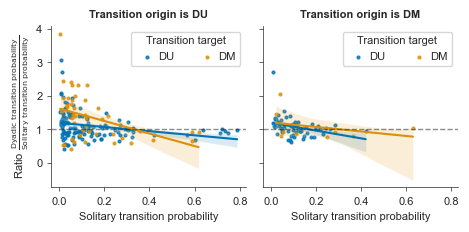

In [28]:
c1, c2 = sns.palettes.color_palette("colorblind")[:2]

f = sns.FacetGrid(data=normed_transition_series, col="source_DM", hue="target_DM", palette=[c1, sig_color])
f.map_dataframe(sns.regplot, x="Solitary", y="ratio")
f.set_titles("{col_name}", weight="bold")

for ax in f.axes.flatten():
    ax.axhline(1, ls="--", c="k", alpha=0.5)
    # add_identity_line(ax, color="k", zorder=1e3)
    # ax.set_aspect("equal")

    ax.set_ylabel(r"Ratio $\frac{\text{Dyadic transition probability}}{\text{Solitary transition probability}}$")
    ax.set_xlabel("Solitary transition probability")
    handles, labels = ax.get_legend_handles_labels()
    labels = ["DM" if l=="True" else "DU" for l in labels]
    ax.legend(handles, labels, title="Transition target", ncols=2, handletextpad=0)

fig = f.fig
fig.subplots_adjust(wspace=.0, hspace=.0)

fig_size_cm = (12, 6)
fig_size = (fig_size_cm[0]/2.54, fig_size_cm[1]/2.54)

fig.set_figwidth(fig_size[0])
fig.set_figheight(fig_size[1])

fig.tight_layout()
fig.savefig(plot_output_dir / "SupplFig3PanelC.svg", dpi=default_dpi)

## Panel D

In [29]:
sylls_needed_to_90_percent = load_object(data_output_dir / "sylls_needed_to_90_percent.pkl")
sylls_needed_to_90_percent["transition_origin"] = sylls_needed_to_90_percent["sig_syll"].apply(lambda x: "DM" if x else "DU")

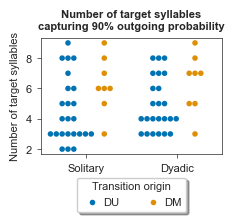

In [30]:
ax = sns.swarmplot(sylls_needed_to_90_percent.reset_index(), x="Context", y="n90", hue="transition_origin", dodge=True, s=4, palette=[c1, sig_color])
ax.set_xlabel("")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=2, handletextpad=0, title="Transition origin")
ax.set_title("Number of target syllables\ncapturing 90% outgoing probability", weight="bold")
ax.set_ylabel("Number of target syllables")


fig = ax.get_figure()

fig_size_cm = (6, 6)
fig_size = (fig_size_cm[0]/2.54, fig_size_cm[1]/2.54)

fig.set_figwidth(fig_size[0])
fig.set_figheight(fig_size[1])

fig.tight_layout()
fig.savefig(plot_output_dir / "SupplFig3PanelD.svg", dpi=default_dpi)

# Supplementary Figure 4

In [31]:
inserted_text_color_dict = {
    (9,0,5): (["(9, 0, ", "5", ")"], ["black", sig_color, "black"]),
    (0,5,9): (["(0, ", "5", ", 9)"], ["black", sig_color, "black"]),
    (21,1,13): (["(21, 1, ", "13", ")"], ["black", sig_color, "black"]),
    }


## Panel A (0, 5, 9)

In [32]:
filtered_pattern_chunks_059 = load_object(data_output_dir / "filtered_pattern_chunks_059.pkl")
normalized_trajectory_df_059 = load_object(data_output_dir / "normalized_trajectory_df_059.pkl")

100%|██████████| 16/16 [01:17<00:00,  4.82s/it]


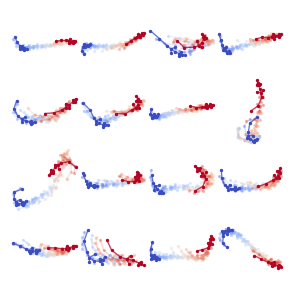

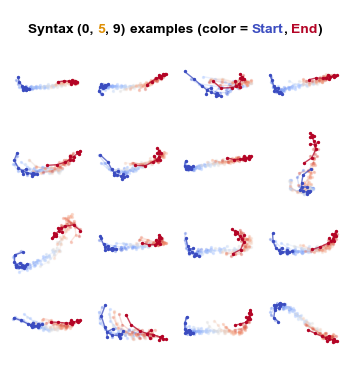

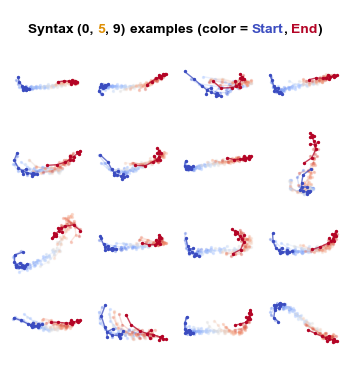

In [33]:
target_size = 256
title_text = None
cmap = sns.color_palette("coolwarm", as_cmap=True)

fig_size_cm = (18, 18)
fig_size = (fig_size_cm[0]/2.54, fig_size_cm[1]/2.54)

fig, axs = plt.subplots(4, 4, figsize=fig_size, sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)
axs.flatten()[0].invert_yaxis()
axs.flatten()[0].set_aspect("equal")

selected_pattern = (0, 5, 9)
median_length = filtered_pattern_chunks_059["length"].median()

for (track, trajectory_df), ax in tqdm(zip(normalized_trajectory_df_059.groupby(["track", "reference_frame_index"]), axs.flatten()), total=len(normalized_trajectory_df_059.groupby(["track", "reference_frame_index"]))):
    ax.axis("off")

    keypoint_df = trajectory_df.stack("keypoint_name", future_stack=True).droplevel(["track", "reference_frame_index"], axis=0)
    keypoint_df = keypoint_df.drop("instance", level=-1, axis=0)  # clean up keypoint df
    plotting_df = normalize_keypoint_df_for_plotting(keypoint_df.loc[np.arange(-5, median_length+5, 5)], target_size=target_size)

    frames = sorted(plotting_df.index.get_level_values(0).unique())

    alpha_series = pd.Series([0.3]*len(frames), index=frames)
    alpha_series.iloc[0], alpha_series.iloc[-1] = 1, 1
    zorder_series = pd.Series([0]*len(frames), index=frames)
    zorder_series.iloc[0], zorder_series.iloc[-1] = 1, 1
    color_df = pd.DataFrame(cmap(np.linspace(0, 1, len(frames))), index=frames)

    for i in frames:
        alpha = alpha_series.loc[i]
        plot_keypoint_instance(plotting_df.loc[i], ax=ax, skeleton_df=skeleton_df, plot_labels=False, 
                               keypoint_kwargs=dict(alpha=alpha, color=tuple(color_df.loc[i])[:3], s=2, zorder=zorder_series.loc[i]), 
                               skeleton_kwargs=dict(alpha=alpha*0.75, color=color_df.loc[i], lw=1, zorder=zorder_series.loc[i]))

    if title_text is not None:
        ax.text(0.5, 1.05, title_text, horizontalalignment="center", verticalalignment="center",
                transform=ax.transAxes, fontsize=12, fontweight="bold")
        
fig_size_cm = (9, 9)
fig_size = (fig_size_cm[0]/2.54, fig_size_cm[1]/2.54)
fig.set_size_inches(fig_size)

fig_copy = copy_figure(fig)
source = fig_copy.suptitle(f"Syntax {selected_pattern} examples (color = Start, End)", fontweight="bold", y=1)

text_list, color_list = inserted_text_color_dict.get(selected_pattern, ([str(selected_pattern)], ["black"]))
rainbow_text(source_text=source, ls=[f"Syntax ", *text_list, " examples (color = ", "Start", ", ", "End", ")"], 
             lc=["black", *color_list, "black", cmap(0), "black", cmap(255), "black"])
fig_copy.subplots_adjust(top=0.92, bottom=0, left=0, right=1, hspace=0, wspace=0)

fig_copy.tight_layout()
fig_copy.savefig(plot_output_dir / "SupplFig4PanelA.svg", dpi=default_dpi)

## Panel B (2, 22, 2)

In [34]:
filtered_pattern_chunks_2222 = load_object(data_output_dir / "filtered_pattern_chunks_2222.pkl")
normalized_trajectory_df_2222 = load_object(data_output_dir / "normalized_trajectory_df_2222.pkl")

100%|██████████| 16/16 [01:09<00:00,  4.35s/it]


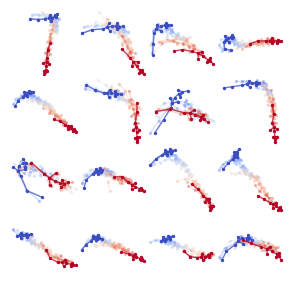

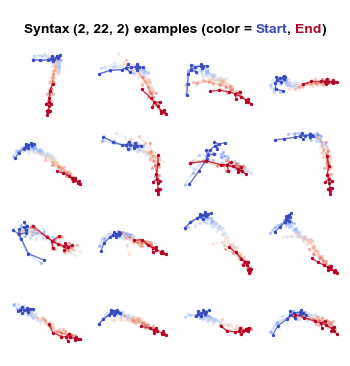

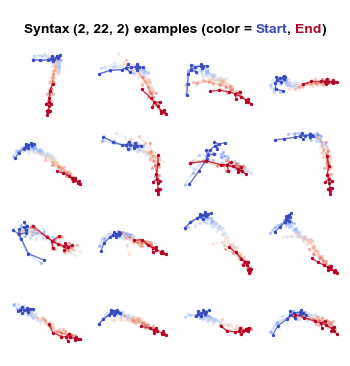

In [35]:
target_size = 256
title_text = None
cmap = sns.color_palette("coolwarm", as_cmap=True)

fig_size_cm = (18, 18)
fig_size = (fig_size_cm[0]/2.54, fig_size_cm[1]/2.54)

fig, axs = plt.subplots(4, 4, figsize=fig_size, sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)
axs.flatten()[0].invert_yaxis()
axs.flatten()[0].set_aspect("equal")

selected_pattern = (2, 22, 2)
median_length = filtered_pattern_chunks_2222["length"].median()

for (track, trajectory_df), ax in tqdm(zip(normalized_trajectory_df_2222.groupby(["track", "reference_frame_index"]), axs.flatten()), total=len(normalized_trajectory_df_2222.groupby(["track", "reference_frame_index"]))):
    ax.axis("off")

    keypoint_df = trajectory_df.stack("keypoint_name", future_stack=True).droplevel(["track", "reference_frame_index"], axis=0)
    keypoint_df = keypoint_df.drop("instance", level=-1, axis=0)  # clean up keypoint df
    plotting_df = normalize_keypoint_df_for_plotting(keypoint_df.loc[np.arange(-5, median_length+5, 5)], target_size=target_size)

    frames = sorted(plotting_df.index.get_level_values(0).unique())

    alpha_series = pd.Series([0.3]*len(frames), index=frames)
    alpha_series.iloc[0], alpha_series.iloc[-1] = 1, 1
    zorder_series = pd.Series([0]*len(frames), index=frames)
    zorder_series.iloc[0], zorder_series.iloc[-1] = 1, 1
    color_df = pd.DataFrame(cmap(np.linspace(0, 1, len(frames))), index=frames)

    for i in frames:
        alpha = alpha_series.loc[i]
        plot_keypoint_instance(plotting_df.loc[i], ax=ax, skeleton_df=skeleton_df, plot_labels=False, 
                               keypoint_kwargs=dict(alpha=alpha, color=tuple(color_df.loc[i])[:3], s=2, zorder=zorder_series.loc[i]), 
                               skeleton_kwargs=dict(alpha=alpha*0.75, color=color_df.loc[i], lw=1, zorder=zorder_series.loc[i]))

    if title_text is not None:
        ax.text(0.5, 1.05, title_text, horizontalalignment="center", verticalalignment="center",
                transform=ax.transAxes, fontsize=12, fontweight="bold")
        
fig_size_cm = (9, 9)
fig_size = (fig_size_cm[0]/2.54, fig_size_cm[1]/2.54)
fig.set_size_inches(fig_size)

fig_copy = copy_figure(fig)
source = fig_copy.suptitle(f"Syntax {selected_pattern} examples (color = Start, End)", fontweight="bold", y=1)

text_list, color_list = inserted_text_color_dict.get(selected_pattern, ([str(selected_pattern)], ["black"]))
rainbow_text(source_text=source, ls=[f"Syntax ", *text_list, " examples (color = ", "Start", ", ", "End", ")"], 
             lc=["black", *color_list, "black", cmap(0), "black", cmap(255), "black"])
fig_copy.subplots_adjust(top=0.92, bottom=0, left=0, right=1, hspace=0, wspace=0)

fig_copy.tight_layout()
fig_copy.savefig(plot_output_dir / "SupplFig4PanelB.svg", dpi=default_dpi)

## Panel C (21, 1, 13)

In [36]:
filtered_pattern_chunks_21113 = load_object(data_output_dir / "filtered_pattern_chunks_21113.pkl")
normalized_trajectory_df_21113 = load_object(data_output_dir / "normalized_trajectory_df_21113.pkl")

100%|██████████| 16/16 [01:24<00:00,  5.27s/it]


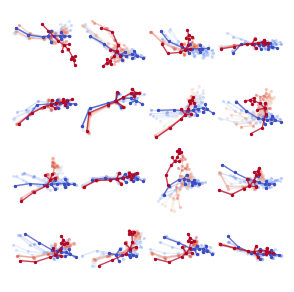

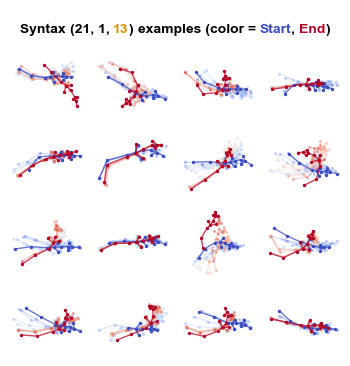

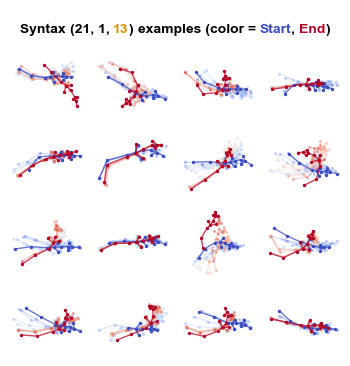

In [37]:
target_size = 256
title_text = None
cmap = sns.color_palette("coolwarm", as_cmap=True)

fig_size_cm = (18, 18)
fig_size = (fig_size_cm[0]/2.54, fig_size_cm[1]/2.54)

fig, axs = plt.subplots(4, 4, figsize=fig_size, sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)
axs.flatten()[0].invert_yaxis()
axs.flatten()[0].set_aspect("equal")

selected_pattern = (21, 1, 13)
median_length = filtered_pattern_chunks_21113["length"].median()

for (track, trajectory_df), ax in tqdm(zip(normalized_trajectory_df_21113.groupby(["track", "reference_frame_index"]), axs.flatten()), total=len(normalized_trajectory_df_21113.groupby(["track", "reference_frame_index"]))):
    ax.axis("off")

    keypoint_df = trajectory_df.stack("keypoint_name", future_stack=True).droplevel(["track", "reference_frame_index"], axis=0)
    keypoint_df = keypoint_df.drop("instance", level=-1, axis=0)  # clean up keypoint df
    plotting_df = normalize_keypoint_df_for_plotting(keypoint_df.loc[np.arange(-5, median_length+5, 5)], target_size=target_size)

    frames = sorted(plotting_df.index.get_level_values(0).unique())

    alpha_series = pd.Series([0.3]*len(frames), index=frames)
    alpha_series.iloc[0], alpha_series.iloc[-1] = 1, 1
    zorder_series = pd.Series([0]*len(frames), index=frames)
    zorder_series.iloc[0], zorder_series.iloc[-1] = 1, 1
    # color_series = pd.Series(["gray"]*len(frames), index=frames)
    # color_series.iloc[0], color_series.iloc[-1] = "blue", "red"
    color_df = pd.DataFrame(cmap(np.linspace(0, 1, len(frames))), index=frames)

    for i in frames:
        alpha = alpha_series.loc[i]
        plot_keypoint_instance(plotting_df.loc[i], ax=ax, skeleton_df=skeleton_df, plot_labels=False, 
                               keypoint_kwargs=dict(alpha=alpha, color=tuple(color_df.loc[i])[:3], s=2, zorder=zorder_series.loc[i]), 
                               skeleton_kwargs=dict(alpha=alpha*0.75, color=color_df.loc[i], lw=1, zorder=zorder_series.loc[i]))

    if title_text is not None:
        ax.text(0.5, 1.05, title_text, horizontalalignment="center", verticalalignment="center",
                transform=ax.transAxes, fontsize=12, fontweight="bold")
        
fig_size_cm = (9, 9)
fig_size = (fig_size_cm[0]/2.54, fig_size_cm[1]/2.54)
fig.set_size_inches(fig_size)

fig_copy = copy_figure(fig)
source = fig_copy.suptitle(f"Syntax {selected_pattern} examples (color = Start, End)", fontweight="bold", y=1)

text_list, color_list = inserted_text_color_dict.get(selected_pattern, ([str(selected_pattern)], ["black"]))
rainbow_text(source_text=source, ls=[f"Syntax ", *text_list, " examples (color = ", "Start", ", ", "End", ")"], 
             lc=["black", *color_list, "black", cmap(0), "black", cmap(255), "black"])
fig_copy.subplots_adjust(top=0.92, bottom=0, left=0, right=1, hspace=0, wspace=0)

fig_copy.tight_layout()
fig_copy.savefig(plot_output_dir / "SupplFig4PanelC.svg", dpi=default_dpi)

## Panel D (2, 8, 29)

In [38]:
filtered_pattern_chunks_2829 = load_object(data_output_dir / "filtered_pattern_chunks_2829.pkl")
normalized_trajectory_df_2829 = load_object(data_output_dir / "normalized_trajectory_df_2829.pkl")

100%|██████████| 16/16 [01:31<00:00,  5.75s/it]


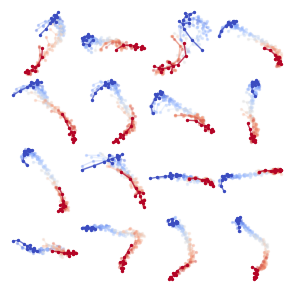

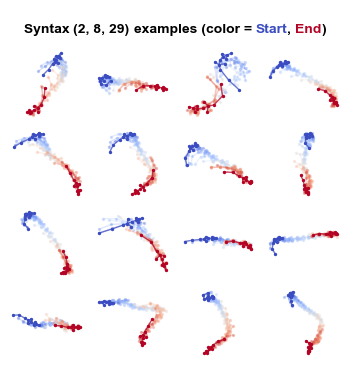

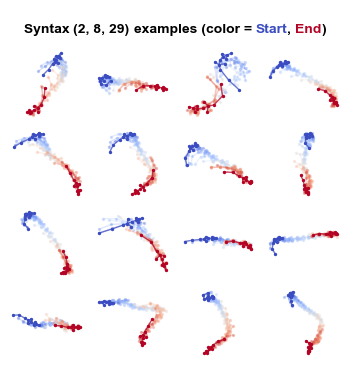

In [39]:
target_size = 256
title_text = None
cmap = sns.color_palette("coolwarm", as_cmap=True)

fig_size_cm = (18, 18)
fig_size = (fig_size_cm[0]/2.54, fig_size_cm[1]/2.54)

fig, axs = plt.subplots(4, 4, figsize=fig_size, sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)
axs.flatten()[0].invert_yaxis()
axs.flatten()[0].set_aspect("equal")

selected_pattern = (2, 8, 29)
median_length = filtered_pattern_chunks_2829["length"].median()

for (track, trajectory_df), ax in tqdm(zip(normalized_trajectory_df_2829.groupby(["track", "reference_frame_index"]), axs.flatten()), total=len(normalized_trajectory_df_2829.groupby(["track", "reference_frame_index"]))):
    ax.axis("off")

    keypoint_df = trajectory_df.stack("keypoint_name", future_stack=True).droplevel(["track", "reference_frame_index"], axis=0)
    keypoint_df = keypoint_df.drop("instance", level=-1, axis=0)  # clean up keypoint df
    plotting_df = normalize_keypoint_df_for_plotting(keypoint_df.loc[np.arange(-5, median_length+5, 5)], target_size=target_size)

    frames = sorted(plotting_df.index.get_level_values(0).unique())

    alpha_series = pd.Series([0.3]*len(frames), index=frames)
    alpha_series.iloc[0], alpha_series.iloc[-1] = 1, 1
    zorder_series = pd.Series([0]*len(frames), index=frames)
    zorder_series.iloc[0], zorder_series.iloc[-1] = 1, 1
    # color_series = pd.Series(["gray"]*len(frames), index=frames)
    # color_series.iloc[0], color_series.iloc[-1] = "blue", "red"
    color_df = pd.DataFrame(cmap(np.linspace(0, 1, len(frames))), index=frames)

    for i in frames:
        alpha = alpha_series.loc[i]
        plot_keypoint_instance(plotting_df.loc[i], ax=ax, skeleton_df=skeleton_df, plot_labels=False, 
                               keypoint_kwargs=dict(alpha=alpha, color=tuple(color_df.loc[i])[:3], s=2, zorder=zorder_series.loc[i]), 
                               skeleton_kwargs=dict(alpha=alpha*0.75, color=color_df.loc[i], lw=1, zorder=zorder_series.loc[i]))

    if title_text is not None:
        ax.text(0.5, 1.05, title_text, horizontalalignment="center", verticalalignment="center",
                transform=ax.transAxes, fontsize=12, fontweight="bold")
        
fig_size_cm = (9, 9)
fig_size = (fig_size_cm[0]/2.54, fig_size_cm[1]/2.54)
fig.set_size_inches(fig_size)

fig_copy = copy_figure(fig)
source = fig_copy.suptitle(f"Syntax {selected_pattern} examples (color = Start, End)", fontweight="bold", y=1)

text_list, color_list = inserted_text_color_dict.get(selected_pattern, ([str(selected_pattern)], ["black"]))
rainbow_text(source_text=source, ls=[f"Syntax ", *text_list, " examples (color = ", "Start", ", ", "End", ")"], 
             lc=["black", *color_list, "black", cmap(0), "black", cmap(255), "black"])
fig_copy.subplots_adjust(top=0.92, bottom=0, left=0, right=1, hspace=0, wspace=0)

fig_copy.tight_layout()
fig_copy.savefig(plot_output_dir / "SupplFig4PanelD.svg", dpi=default_dpi)

# Supplementary Figure 5

In [40]:
inserted_text_color_dict = {
    (9,0,5): (["(9, 0, ", "5", ")"], ["black", sig_color, "black"]),
    (0,5,9): (["(0, ", "5", ", 9)"], ["black", sig_color, "black"]),
    (21,1,13): (["(21, 1, ", "13", ")"], ["black", sig_color, "black"]),
    }


## Panel A (9, 0, 5) Family

In [41]:
filtered_pattern_chunks_905_family = load_object(data_output_dir / "filtered_pattern_chunks_905_family.pkl")
normalized_trajectory_df_905_family = load_object(data_output_dir / "normalized_trajectory_df_905_family.pkl")

100%|██████████| 16/16 [01:17<00:00,  4.86s/it]


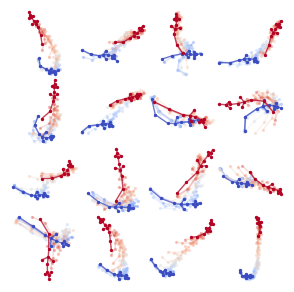

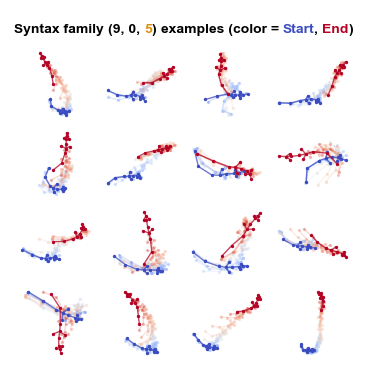

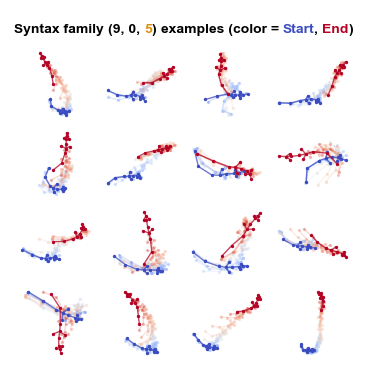

In [42]:
target_size = 256
title_text = None
cmap = sns.color_palette("coolwarm", as_cmap=True)

fig_size_cm = (18, 18)
fig_size = (fig_size_cm[0]/2.54, fig_size_cm[1]/2.54)

fig, axs = plt.subplots(4, 4, figsize=fig_size, sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)
axs.flatten()[0].invert_yaxis()
axs.flatten()[0].set_aspect("equal")

selected_pattern = (9, 0, 5)
median_length = filtered_pattern_chunks_905_family["length"].median()

for (track, trajectory_df), ax in tqdm(zip(normalized_trajectory_df_905_family.groupby(["track", "reference_frame_index"]), axs.flatten()), total=len(normalized_trajectory_df_905_family.groupby(["track", "reference_frame_index"]))):
    ax.axis("off")

    keypoint_df = trajectory_df.stack("keypoint_name", future_stack=True).droplevel(["track", "reference_frame_index"], axis=0)
    keypoint_df = keypoint_df.drop("instance", level=-1, axis=0)  # clean up keypoint df
    plotting_df = normalize_keypoint_df_for_plotting(keypoint_df.loc[np.arange(-5, median_length+5, 5)], target_size=target_size)

    frames = sorted(plotting_df.index.get_level_values(0).unique())

    alpha_series = pd.Series([0.3]*len(frames), index=frames)
    alpha_series.iloc[0], alpha_series.iloc[-1] = 1, 1
    zorder_series = pd.Series([0]*len(frames), index=frames)
    zorder_series.iloc[0], zorder_series.iloc[-1] = 1, 1
    # color_series = pd.Series(["gray"]*len(frames), index=frames)
    # color_series.iloc[0], color_series.iloc[-1] = "blue", "red"
    color_df = pd.DataFrame(cmap(np.linspace(0, 1, len(frames))), index=frames)

    for i in frames:
        alpha = alpha_series.loc[i]
        plot_keypoint_instance(plotting_df.loc[i], ax=ax, skeleton_df=skeleton_df, plot_labels=False, 
                               keypoint_kwargs=dict(alpha=alpha, color=tuple(color_df.loc[i])[:3], s=2, zorder=zorder_series.loc[i]), 
                               skeleton_kwargs=dict(alpha=alpha*0.75, color=color_df.loc[i], lw=1, zorder=zorder_series.loc[i]))

    if title_text is not None:
        ax.text(0.5, 1.05, title_text, horizontalalignment="center", verticalalignment="center",
                transform=ax.transAxes, fontsize=12, fontweight="bold")
        
fig_size_cm = (9, 9)
fig_size = (fig_size_cm[0]/2.54, fig_size_cm[1]/2.54)
fig.set_size_inches(fig_size)

fig_copy = copy_figure(fig)
source = fig_copy.suptitle(f"Syntax family {selected_pattern} examples (color = Start, End)", fontweight="bold", y=1)

text_list, color_list = inserted_text_color_dict.get(selected_pattern, ([str(selected_pattern)], ["black"]))
rainbow_text(source_text=source, ls=[f"Syntax family ", *text_list, " examples (color = ", "Start", ", ", "End", ")"], 
             lc=["black", *color_list, "black", cmap(0), "black", cmap(255), "black"])
fig_copy.subplots_adjust(top=0.92, bottom=0, left=0, right=1, hspace=0, wspace=0)

fig_copy.tight_layout()
fig_copy.savefig(plot_output_dir / "SupplFig5PanelA.svg", dpi=default_dpi)

## Panel B (11, 2, 8) Family

In [43]:
filtered_pattern_chunks_1128_family = load_object(data_output_dir / "filtered_pattern_chunks_1128_family.pkl")
normalized_trajectory_df_1128_family = load_object(data_output_dir / "normalized_trajectory_df_1128_family.pkl")

100%|██████████| 16/16 [01:18<00:00,  4.88s/it]


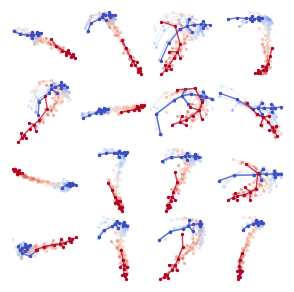

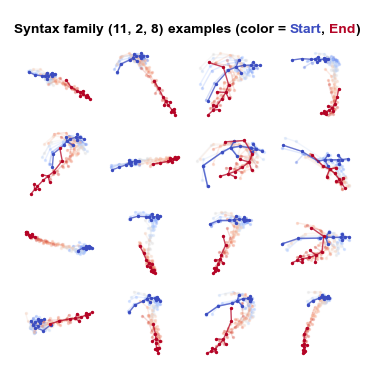

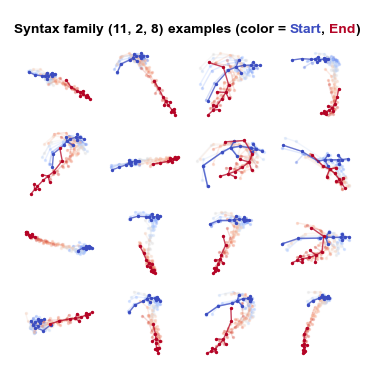

In [44]:
target_size = 256
title_text = None
cmap = sns.color_palette("coolwarm", as_cmap=True)

fig_size_cm = (18, 18)
fig_size = (fig_size_cm[0]/2.54, fig_size_cm[1]/2.54)

fig, axs = plt.subplots(4, 4, figsize=fig_size, sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)
axs.flatten()[0].invert_yaxis()
axs.flatten()[0].set_aspect("equal")

selected_pattern = (11, 2, 8)
median_length = filtered_pattern_chunks_1128_family["length"].median()

for (track, trajectory_df), ax in tqdm(zip(normalized_trajectory_df_1128_family.groupby(["track", "reference_frame_index"]), axs.flatten()), total=len(normalized_trajectory_df_1128_family.groupby(["track", "reference_frame_index"]))):
    ax.axis("off")

    keypoint_df = trajectory_df.stack("keypoint_name", future_stack=True).droplevel(["track", "reference_frame_index"], axis=0)
    keypoint_df = keypoint_df.drop("instance", level=-1, axis=0)  # clean up keypoint df
    plotting_df = normalize_keypoint_df_for_plotting(keypoint_df.loc[np.arange(-5, median_length+5, 5)], target_size=target_size)

    frames = sorted(plotting_df.index.get_level_values(0).unique())

    alpha_series = pd.Series([0.3]*len(frames), index=frames)
    alpha_series.iloc[0], alpha_series.iloc[-1] = 1, 1
    zorder_series = pd.Series([0]*len(frames), index=frames)
    zorder_series.iloc[0], zorder_series.iloc[-1] = 1, 1
    # color_series = pd.Series(["gray"]*len(frames), index=frames)
    # color_series.iloc[0], color_series.iloc[-1] = "blue", "red"
    color_df = pd.DataFrame(cmap(np.linspace(0, 1, len(frames))), index=frames)

    for i in frames:
        alpha = alpha_series.loc[i]
        plot_keypoint_instance(plotting_df.loc[i], ax=ax, skeleton_df=skeleton_df, plot_labels=False, 
                               keypoint_kwargs=dict(alpha=alpha, color=tuple(color_df.loc[i])[:3], s=2, zorder=zorder_series.loc[i]), 
                               skeleton_kwargs=dict(alpha=alpha*0.75, color=color_df.loc[i], lw=1, zorder=zorder_series.loc[i]))

    if title_text is not None:
        ax.text(0.5, 1.05, title_text, horizontalalignment="center", verticalalignment="center",
                transform=ax.transAxes, fontsize=12, fontweight="bold")
        
fig_size_cm = (9, 9)
fig_size = (fig_size_cm[0]/2.54, fig_size_cm[1]/2.54)
fig.set_size_inches(fig_size)

fig_copy = copy_figure(fig)
source = fig_copy.suptitle(f"Syntax family {selected_pattern} examples (color = Start, End)", fontweight="bold", y=1)

text_list, color_list = inserted_text_color_dict.get(selected_pattern, ([str(selected_pattern)], ["black"]))
rainbow_text(source_text=source, ls=[f"Syntax family ", *text_list, " examples (color = ", "Start", ", ", "End", ")"], 
             lc=["black", *color_list, "black", cmap(0), "black", cmap(255), "black"])
fig_copy.subplots_adjust(top=0.92, bottom=0, left=0, right=1, hspace=0, wspace=0)

fig_copy.tight_layout()
fig_copy.savefig(plot_output_dir / "SupplFig5PanelB.svg", dpi=default_dpi)

# Supplementary Figure 6

## Panel A

In [45]:
def intersperse(lst, item):
    """
    from https://stackoverflow.com/a/5921708
    """
    result = [item] * (len(lst) * 2 - 1)
    result[0::2] = lst
    return result


def _color_legend_sylls(input_legend):
    for l in input_legend.get_texts():
        t_text = l.get_text()
        if not "(" in t_text:
            continue
        t_sylls = [str(s) for s in eval(t_text)]
        syll_texts = ["(", *intersperse(t_sylls, ", "), ")"]
        sig_syll_strings = [str(s) for s in sig_syllables]
        syll_colors = [sig_color if s in sig_syll_strings else "black" for s in syll_texts]
        print(syll_texts, syll_colors, sig_syll_strings)
        b = rainbow_text(l, syll_texts, syll_colors)
        b.set_zorder(100)
        # only looks uneven, pdf is fine


In [46]:
cmap = plt.get_cmap("Set3")

polygon_colors = {
    "contact": cmap(0),
    "approach": cmap(3),
    "leave": cmap(2),
    "contact_control": cmap(0),
    "approach_control": cmap(3),
    "leave_control": cmap(2),
}

rename_dict = {
    "targeted_approach": "approach",
    "targeted_leave": "leave",
    "stationary_no_contact": "contact_control",
}

second_rename_dict = {
    "contact": "a",
    "approach": "b",
    "leave": "c",
    "contact_control": "a$_{ctrl}$",
    "approach_control": "b$_{ctrl}$",
    "leave_control": "c$_{ctrl}$",
}

['(', '9', ', ', '0', ', ', '5', ')'] ['black', 'black', 'black', 'black', 'black', (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), 'black'] ['5', '7', '10', '12', '13', '18', '23', '30']
['(', '11', ', ', '2', ', ', '8', ')'] ['black', 'black', 'black', 'black', 'black', 'black', 'black'] ['5', '7', '10', '12', '13', '18', '23', '30']


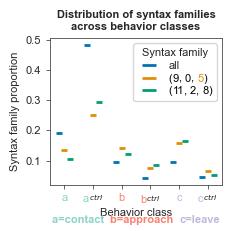

In [47]:
syllable_family_polygon_ratio_series = load_object(data_output_dir / "syllable_family_polygon_ratio_series.pkl")

rename_dict = {
    "contact": "a",
    "stationary_no_contact": "a$_{ctrl}$",
    "targeted_approach": "b",
    "approach_control": "b$_{ctrl}$",
    "targeted_leave": "c",
    "leave_control": "c$_{ctrl}$"
}

_index_df = syllable_family_polygon_ratio_series.index.to_frame()
_index_df.loc[:, "containing_polygon"] = _index_df.loc[:, "containing_polygon"].apply(lambda x: rename_dict.get(x, x))
syllable_family_polygon_ratio_series.index = pd.MultiIndex.from_frame(_index_df)

ax = sns.pointplot(
    data=syllable_family_polygon_ratio_series.rename("occurrence").reset_index(), 
    x="containing_polygon", order=list(rename_dict.values()),
    y="occurrence", 
    hue="syllable_pattern", hue_order=["all", "(9, 0, 5)", "(11, 2, 8)"], palette="colorblind",
    dodge=.4, linestyle="none", errorbar=None,
    marker="_", markersize=4, markeredgewidth=2,
)
ax.set_ylabel("Syntax family proportion")

handles, labels = ax.get_legend_handles_labels()
for h in handles:
    h.set_markersize(10)
ax.legend(handles, labels, title="Syntax family", labelspacing=0.25)
l = ax.get_legend()
_color_legend_sylls(l)

fig = ax.get_figure()

fig_size_cm = (6, 6)
fig_size = (fig_size_cm[0]/2.54, fig_size_cm[1]/2.54)

fig.set_figwidth(fig_size[0])
fig.set_figheight(fig_size[1])

ax.set_title("Distribution of syntax families\nacross behavior classes", fontweight="bold")

ax.tick_params(axis="x", pad=-3)

inverted_rename_dict = invert_flat_dict(second_rename_dict, unpack_single_values=True)
for ticklabel in ax.get_xticklabels():
    ticklabel_text = ticklabel.get_text()
    if len(ticklabel_text) > 1:
        rainbow_text(ticklabel, ls=[ticklabel_text[:1], ticklabel_text[1:]], lc=[polygon_colors[inverted_rename_dict[ticklabel_text]], "k"])
    else:
        rainbow_text(ticklabel, ls=[ticklabel_text], lc=[polygon_colors[inverted_rename_dict[ticklabel_text]]])

fig.tight_layout()
fig.subplots_adjust(bottom=0.21)
ax.set_xlabel("Behavior class", labelpad=7)

# add a text legend in left lower corner mapping a letter to a syntax class
legend_string = "a=contact  b=approach  c=leave"
legend_text = ax.text(0.5, -0.15, legend_string, ha='center', va='top', transform=ax.transAxes, fontsize=SMALL_SIZE, fontweight="bold")
rainbow_text(legend_text, ls=["a=contact  ", "b=approach  ", "c=leave"], lc=[polygon_colors["contact"], polygon_colors["approach"], polygon_colors["leave"]])

fig.savefig(plot_output_dir / "SupplFig6PanelA.svg", dpi=default_dpi)

## Panel B

In [48]:
syntax_polygon_dkl_series = load_object(data_output_dir / "syntax_polygon_dkl_series.pkl")

In [49]:
# rename index entries with rename_dict
syntax_polygon_dkl_series = syntax_polygon_dkl_series.rename(rename_dict)

syntax_polygon_dkl_series = syntax_polygon_dkl_series.rename(second_rename_dict)
syntax_polygon_dkl_series

polygon1    polygon2  
b$_{ctrl}$  a             0.495133
            c$_{ctrl}$    0.263745
            a$_{ctrl}$    0.613449
            b             0.224591
            c             0.223551
a           b$_{ctrl}$    1.187240
            c$_{ctrl}$    0.571326
            a$_{ctrl}$    0.100581
            b             0.392471
            c             0.528813
c$_{ctrl}$  b$_{ctrl}$    0.738533
            a             0.420840
            a$_{ctrl}$    0.509458
            b             0.218510
            c             0.249918
a$_{ctrl}$  b$_{ctrl}$    1.336830
            a             0.104766
            c$_{ctrl}$    0.624417
            b             0.584730
            c             0.766711
b           b$_{ctrl}$    0.484085
            a             0.375293
            c$_{ctrl}$    0.188100
            a$_{ctrl}$    0.488387
            c             0.157219
c           b$_{ctrl}$    0.439913
            a             0.445940
            c$_{ctrl}$    0.1865

C:\Users\rittmart\AppData\Local\Temp\ipykernel_105320\2817747529.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  labels = data.applymap(lambda x: ("%.2f"%x)[1:] if not pd.isna(x) else "")
C:\Users\rittmart\AppData\Local\Temp\ipykernel_105320\2817747529.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


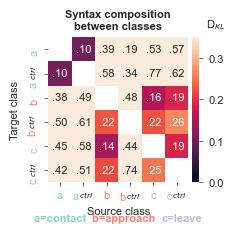

In [50]:
target_order = ["contact", "contact_control", "approach", "approach_control", "leave", "leave_control"]
# rename target order with second rename dict
target_order = [second_rename_dict.get(x, x) for x in target_order]

fig_size_cm = (6, 6)
fig_size = (fig_size_cm[0]/2.54, fig_size_cm[1]/2.54)

fig, ax = plt.subplots(figsize=fig_size)

axins = inset_axes(ax,
                    width="5%",  
                    height="100%",
                    loc='right',
                    borderpad=-1
                   )

data = syntax_polygon_dkl_series.unstack("polygon2").loc[target_order, target_order]
labels = data.applymap(lambda x: ("%.2f"%x)[1:] if not pd.isna(x) else "")
sns.heatmap(data, vmin=0, vmax=0.35, annot=labels, cbar=True, cbar_ax=axins, ax=ax, fmt="")

axins.annotate("D$_{KL}$", xy=(2.0, 1.04), xycoords="axes fraction", ha="left", va="bottom", annotation_clip=False, size=SMALL_SIZE)

ax.set_xlabel("Source class")
ax.set_ylabel("Target class")
ax.set_title("Syntax composition\nbetween classes", fontweight="bold", fontsize=SMALL_SIZE)

# add a text legend in left lower corner mapping a letter to a syntax class
legend_string = "a=contact  b=approach  c=leave"
legend_text = ax.text(0.5, -0.16, legend_string, ha='center', va='top', transform=ax.transAxes, fontsize=SMALL_SIZE, fontweight="bold")
rainbow_text(legend_text, ls=["a=contact  ", "b=approach  ", "c=leave"], lc=[polygon_colors["contact"], polygon_colors["approach"], polygon_colors["leave"]])

inverted_rename_dict = invert_flat_dict(second_rename_dict, unpack_single_values=True)
for ticklabel in ax.get_xticklabels():
    ticklabel_text = ticklabel.get_text()
    if len(ticklabel_text) > 1:
        rainbow_text(ticklabel, ls=[ticklabel_text[:1], ticklabel_text[1:]], lc=[polygon_colors[inverted_rename_dict[ticklabel_text]], "k"])
    else:
        rainbow_text(ticklabel, ls=[ticklabel_text], lc=[polygon_colors[inverted_rename_dict[ticklabel_text]]])

for ticklabel in ax.get_yticklabels():
    ticklabel_text = ticklabel.get_text()
    if len(ticklabel_text) > 1:
        rainbow_text(ticklabel, ls=[ticklabel_text[:1], ticklabel_text[1:]], lc=[polygon_colors[inverted_rename_dict[ticklabel_text]], "k"])
    else:
        rainbow_text(ticklabel, ls=[ticklabel_text], lc=[polygon_colors[inverted_rename_dict[ticklabel_text]]])

ax.tick_params(axis="x", pad=-3)
ax.set_xlabel("Source class", labelpad=7)
fig.subplots_adjust(right=0.55)
fig.set_size_inches(fig_size)

fig.tight_layout()

fig.savefig(plot_output_dir / "SupplFig6PanelB.svg", dpi=default_dpi)

## Panel C

In [51]:
global_match_df_copy = load_object(data_output_dir / "global_match_df_copy.pkl")
clean_polygon_dict = load_object(data_output_dir / "clean_polygon_dict.pkl")

C:\Users\rittmart\AppData\Local\Temp\ipykernel_105320\4226783353.py:43: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


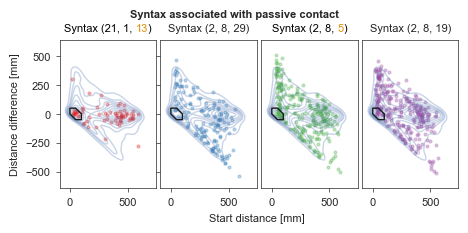

In [52]:
target_patterns = [(21, 1, 13), (2, 8, 29), (2, 8, 5), (2, 8, 19)]

pattern_strings_and_colors = {
    (21, 1, 13): (["Syntax (21, 1, ", "13", ")"], ["black", sig_color, "black"]),
    (2, 8, 5): (["Syntax (2, 8, ", "5", ")"], ["black", sig_color, "black"]),
}

fig_size_cm = (12, 6)
fig_size = (fig_size_cm[0]/2.54, fig_size_cm[1]/2.54)

fig, axs = plt.subplots(1, len(target_patterns), figsize=fig_size, sharey=True)
cmap = sns.color_palette("Set1", len(target_patterns))

for i, (target_pattern, pattern_ax) in enumerate(zip(target_patterns, axs.flatten())):
    sns.kdeplot(global_match_df_copy, x="start_distance", y="distance_difference", ax=pattern_ax, alpha=0.3)
    pattern_match_df = global_match_df_copy[global_match_df_copy["syllable_match"] == target_pattern]

    pattern_ax.scatter(x=pattern_match_df["start_distance"], y=pattern_match_df["distance_difference"], alpha=0.3, color=cmap[i])
    plot_polygon(clean_polygon_dict["contact"], name=None, ax=pattern_ax, polygon_kwargs=dict(fill=False, alpha=1, color="k", zorder=10))

    pattern_ax.set_title(f"Syntax {target_pattern}")

    if target_pattern in pattern_strings_and_colors:
        rainbow_text(pattern_ax.title, *pattern_strings_and_colors[target_pattern])

    if i==1:
        pattern_ax.set_xlabel("Start distance [mm]")
        pattern_ax.xaxis.set_label_coords(x=1, y=-0.17)
    else:
        pattern_ax.set_xlabel("")
        pattern_ax.tick_params(axis="y", left=False)
    if i==0:
        pattern_ax.tick_params(axis="y", left=True)
    pattern_ax.set_ylabel("Distance difference [mm]")
    pattern_ax.set_ylim([-diagonal_length, diagonal_length])
    pattern_ax.set_aspect('equal', adjustable='datalim')

fig.suptitle("Syntax associated with passive contact", weight="bold", fontsize=SMALL_SIZE)
plt.tight_layout()
fig.subplots_adjust(top=0.85, wspace=0.05)

fig.savefig(plot_output_dir / "SupplFig6PanelC.svg", dpi=default_dpi)
fig.show()